### A. Goldman, N. Puchkin, V. Shcherbakova, and U. Vinogradova

### Numerical experiments on Occupancy data set, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [1]:
import json
import pandas as pd
import os

from tqdm import tqdm
from os import listdir
import numpy as np
from os.path import join
import numpy as np
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cvxpy as cvx
import joblib

%matplotlib inline

In [2]:
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.contrastive_change_point import compute_test_stat_nn
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd

In [3]:
%reload_ext autoreload
%autoreload 2

## Auxiliary functions

In [4]:
def load_data(filename, cp=False):
    with open(filename, "rb") as fid:
        data = json.load(fid)
    title = data["name"]
    y = data["series"][0]["raw"]
    if "time" in data and "format" in data["time"]:
        fmt = data["time"]["format"]
        if fmt == "%Y.%F":
            x = list(map(frac_to_dt, data["time"]["raw"]))
        else:
            try:
                x = pd.to_datetime(
                    data["time"]["raw"], format=data["time"]["format"]
                )
            except ValueError:
                x = list(range(1, len(y) + 1))
    else:
        x = list(range(1, len(y) + 1))
    as_dict = {"x": x}
    for idx, series in enumerate(data["series"]):
        as_dict["y" + str(idx)] = series["raw"]

    df = pd.DataFrame(as_dict)
    if cp:
        with open('data/occupancy/annotations.json') as json_file:
            changepoints_dict = json.load(json_file)
    
        changepoints = changepoints_dict[title]
        return df, title, changepoints
    
    return df, title


In [5]:
def plot_data_with_cp(input_data, interval=[0,-1], changepoints=None, color="#000066"):
    
    colors = ['#000066', '#006600', '#ff0066', '#800000', '#9933ff']

    if isinstance(input_data, str):
        df, title = load_data(input_data)
    else:
         df, title = input_data

    if color is None:
        color = "blue"
    fig, axes = plt.subplots(df.shape[1] - 1, 1, squeeze=False)
    for idx, col in enumerate(df.columns[1:]):
        x = df.index
        y = df[col]

        if interval != [0,-1]:
            x = x[interval[0]: interval[1]]
            y = y[interval[0]: interval[1]]

            if not changepoints is None:
                changepoints = changepoints[(changepoints >= interval[0]) & (changepoints <= interval[1])]

        axes[idx, 0].scatter(x, y, color=color, s=10)
        axes[idx, 0].plot(x, y, color=color)

        if not changepoints is None:
             axes[idx, 0].vlines(x=changepoints, ymin=y.min(), ymax=y.max(), colors='#ff00bf', ls=':', lw=1.5)


    fig.suptitle(title)

In [6]:
# import random

# def set_random_seed(seed):
#     torch.backends.cudnn.deterministic = True
   
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(seed)

# set_random_seed(46)

torch.manual_seed(1)

In [7]:
def parse_cp(df, cp):
    freq_dict = {}
    for k, v in cp.items():
        for key in v:
            freq_dict[key] = freq_dict.get(key, 0) + 1
    
    myKeys = list(freq_dict.keys())
    myKeys.sort()
    sorted_dict = {i: freq_dict[i] for i in myKeys}
    return sorted_dict

def merge_keys(sorted_dict, eps=2): # inplace

    flag = 0
    keys = list(sorted_dict.keys())
    for key in keys:
        if flag == 0:
            flag = 1
            prev_key = key
            key_to_write = key
            continue
        
        if key - prev_key <= eps:
            sorted_dict[key_to_write] += sorted_dict[key]
            _ = sorted_dict.pop(key, 0)
        else:
            key_to_write = key
        
        prev_key = key

def filter_keys(sorted_dict, cp_treshold=2):
    cps = []
    for k, v in sorted_dict.items():
        if v >= cp_treshold:
            cps.append(k)
    return cps


In [8]:
def change_series(df, type_change=None):
    if type_change is None:
        return df
    
    cols = df.columns[1:]
    new_df = pd.DataFrame(columns=['x'].extend(cols))
    new_df['x'] = df['x'][:-1]
    for c in cols:
        if type_change == 'log_simple':
            new_df[c] = (np.log1p(np.roll(df[c], -1)) - np.log1p(df[c]))[:-1]
        elif type_change == 'lin':
            new_df[c] = (np.roll(df[c], -1) - df[c])[:-1]
        else:
            new_df[c] = np.log1p(abs(np.roll(df[c], -1) -df[c]) / abs(df[c] + 1))[:-1]

    return new_df

### Occupancy data set

In [9]:
data_name = "occupancy"

path = f"data/{data_name}/{data_name}.json"

data, title, not_parsed_cp = load_data(path, cp=True)
myDict = parse_cp(data, not_parsed_cp)
merge_keys(myDict, eps=2)
cps = filter_keys(myDict, cp_treshold=2)
cps.append(325)
cps = np.array(cps)
cps

array([ 52,  91, 142, 181, 234, 415, 451, 506, 325])

In [10]:
data.head()

,x,y0,y1,y2,y3
0,2015-02-04 17:51:00,23.18,27.272000,426.0,721.250000
1,2015-02-04 18:07:00,23.00,27.200000,0.0,681.500000
2,2015-02-04 18:23:00,22.70,27.500000,0.0,667.000000
3,2015-02-04 18:39:00,22.50,27.500000,0.0,640.000000
4,2015-02-04 18:55:00,22.29,27.356667,0.0,616.333333


In [11]:
# log_simple, lin, log_diff 
df = change_series(data, type_change="log_diff")

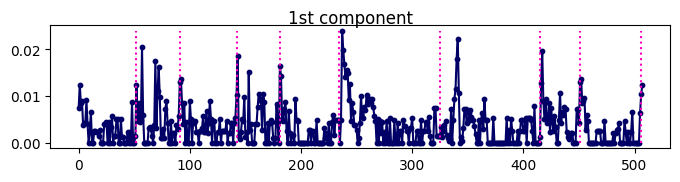

In [12]:
plt.rcParams["figure.figsize"] = (8, 1.6)
plot_data_with_cp((df.iloc[:, 0:2], "1st component"), changepoints=cps)
plt.show()

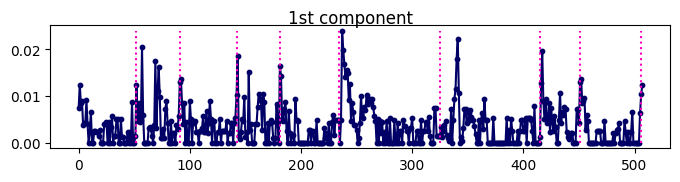

In [13]:
plt.rcParams["figure.figsize"] = (8, 1.6)
plot_data_with_cp((df.iloc[:, 0:2], "1st component"), changepoints=cps)
plt.show()

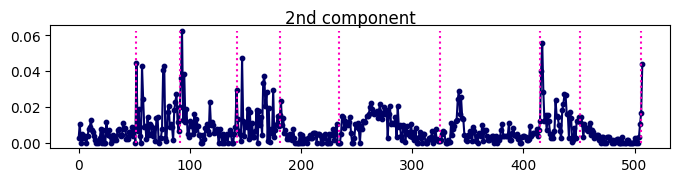

In [14]:
plt.rcParams["figure.figsize"] = (8, 1.6)
plot_data_with_cp((df.iloc[:, 1:3], "2nd component"), changepoints=cps)
plt.show()

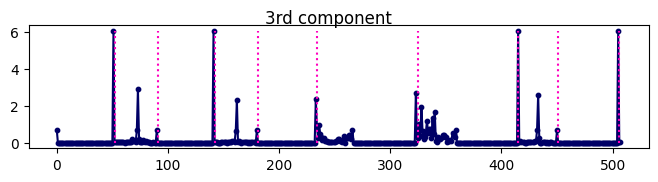

In [15]:
plt.rcParams["figure.figsize"] = (8, 1.6)
plot_data_with_cp((df.iloc[:, 2:4], "3rd component"), changepoints=cps)
plt.show()

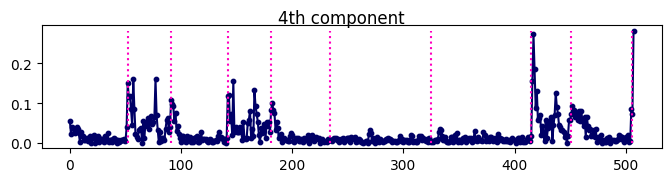

In [16]:
plt.rcParams["figure.figsize"] = (8, 1.6)
plot_data_with_cp((df.iloc[:, 3:5], "4th component"), changepoints=cps)
plt.show()

In [17]:
cps.sort()
change_points = cps
change_points

array([ 52,  91, 142, 181, 234, 325, 415, 451, 506])

In [18]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data = df.iloc[:, 1:].values
data_stationary = [data[:90, :]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = 0
val_end = 300
data_val = data[val_start:val_end]

# Test part: check the performance of the procedures
test_start = 300
data_test = data[test_start:]

### Fast contrastive change point detection algorithm

In [31]:
verbose = False
min_diff = 5

p = 5

# The list of hyperparameters
beta_list = np.linspace(0.01, 0.2, 10)

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='multivariate', delta_max=70)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z - 3.25, z + 0.6, 10)
    print(zs)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        if z < 0 :
            continue
    # Initialization of the test statistic
        S_ftal = np.empty(0)

        # Initialization of the list of detected change points
        change_points_ftal = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_ftal = np.empty(0)
        current_change_point_ind = 0
        false_alarms_ftal = 0

        # Initialization
        st_ftal = 0
        new_st_ftal = 0
        
        while new_st_ftal >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            try:
                new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b, \
                                                        design='multivariate', threshold=z,  delta_max=70)
            except ValueError:
                print(f"Matrix is not positive semi definite")
                break
            
            S_ftal = np.append(S_ftal, new_S_ftal)

            st_ftal += new_st_ftal
            change_points_ftal += [int(st_ftal)]

            if(new_st_ftal > 0):
                if verbose:  
                    print('Detected change point:', st_ftal)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_ftal > min_diff)):
                    if verbose: 
                        print("False Alarm")
                    false_alarms_ftal += 1
                else:
                    skipped_cp = 0

                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_ftal:
                        
                        #skipped change points delays TODO:
                        if skipped_cp > 0:
                            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_ftal <= min_diff):
                        delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)

                        #skipped change points delays TODO:
                        if skipped_cp > 0:
                            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_ftal = np.append(delays_ftal,\
                                        np.array([st_ftal - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)

        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_ftal = np.append(delays_ftal, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break
            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1

        print(f'FTAL, threshold = {z}, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
            '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal), '\n')

Validation change points: [ 52  91 142 181 234]
[-2.28388885 -1.85611107 -1.4283333  -1.00055552 -0.57277774 -0.14499996
  0.28277782  0.71055559  1.13833337  1.56611115]
FTAL, threshold = 0.2827778152503102, beta = 0.01 . Number of false alarms: 2 ; average delay: 17.6 ± 17.85049018934774 

FTAL, threshold = 0.7105555930280882, beta = 0.01 . Number of false alarms: 1 ; average delay: 18.6 ± 19.509997437211517 

FTAL, threshold = 1.1383333708058658, beta = 0.01 . Number of false alarms: 1 ; average delay: 13.0 ± 14.422205101855956 

FTAL, threshold = 1.5661111485836434, beta = 0.01 . Number of false alarms: 1 ; average delay: 22.8 ± 11.923086848631105 

[0.2372347  0.66501248 1.09279026 1.52056804 1.94834581 2.37612359
 2.80390137 3.23167915 3.65945692 4.0872347 ]
FTAL, threshold = 0.23723470262380975, beta = 0.03111111111111111 . Number of false alarms: 4 ; average delay: 15.0 ± 20.823064135712592 

FTAL, threshold = 0.6650124804015876, beta = 0.03111111111111111 . Number of false ala

In [19]:
# TRAIN
verbose=True
min_diff = 5
b = 0.07333333333333333 
z = 0.4040962897256897

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print(change_points_val)


S_ftal_train = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and
# the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0

while new_st_ftal >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    try:
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], 1, beta=b, \
                                                design='multivariate', threshold=z,  delta_max=70)
    except ValueError:
        print(f"Matrix is not positive semi definite")
        break
    
    S_ftal_train = np.append(S_ftal_train, new_S_ftal)

    st_ftal += new_st_ftal
    change_points_ftal += [int(st_ftal)]

    if(new_st_ftal > 0):
        if verbose:  
            print('Detected change point:', st_ftal)

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_ftal > min_diff)):
            if verbose: 
                print("False Alarm")
            false_alarms_ftal += 1
        else:
            skipped_cp = 0

            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_ftal:
                
                #skipped change points delays
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_ftal <= min_diff):
                delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)

                #skipped change points delays
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_ftal = np.append(delays_ftal,\
                                np.array([st_ftal - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_ftal = np.append(delays_ftal, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break
    delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal))

[ 52  91 142 181 234]
Detected change point: 52
Detected change point: 90
Detected change point: 142
Detected change point: 188
Detected change point: 236
Detected change point: 263
False Alarm
FTAL, beta = 0.07333333333333333 . Number of false alarms: 1 ; average delay: 1.8 ± 2.7129319932501077


In [20]:
#TEST
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------
verbose=True
min_diff = 5
b = 0.07333333333333333 
z = 0.4040962897256897


# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
    
# Initialization of the test statistic
S_ftal_test = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_test[st_ftal + 1:], 1, beta=b,\
                                                       design='multivariate', threshold=z,  delta_max=70)

    S_ftal_test = np.append(S_ftal_test, new_S_ftal)

    st_ftal += new_st_ftal
    change_points_ftal += [int(st_ftal)]
    if(new_st_ftal > 0):
        if verbose:  
            print('Detected change point:', st_ftal)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_ftal > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_ftal += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_ftal:
                
                #skipped change points delays
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_ftal <= min_diff):
                delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)
                #skipped change points delays
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)
                
                current_change_point_ind += 1
                continue
            
            delays_ftal = np.append(delays_ftal,\
                                   np.array([st_ftal - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

            
while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_ftal = np.append(delays_ftal, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break
    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal))

Test change points: [ 25 115 151 206]
Detected change point: 26
Detected change point: 52
False Alarm
Detected change point: 88
False Alarm
Detected change point: 116
Detected change point: 170
Detected change point: 206
FTAL, beta = 0.07333333333333333 . Number of false alarms: 2 ; average delay: 5.25 ± 7.949056547792323


In [22]:
# joblib.dump(S_ftal_test,  'stats/S_ftal_test_occup.joblib')

#### Final plot

In [21]:
s_ftal = np.concatenate([S_ftal_train, np.array([0] * (data_val.shape[0] - S_ftal_train.shape[0])), S_ftal_test])
s_ftal.shape

(518,)

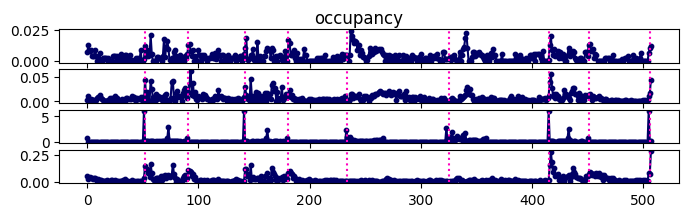

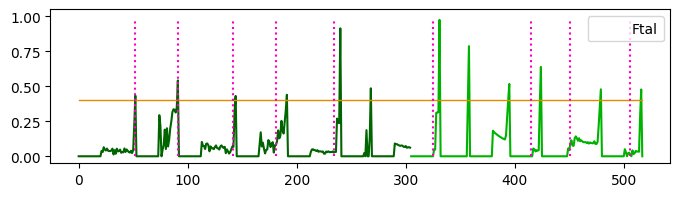

In [23]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp((df, title), changepoints=cps)
plt.show()

s_ftal_train = np.concatenate([S_ftal_train, np.array([0] * (data_val.shape[0] - S_ftal_train.shape[0]))])
all_data = s_ftal.shape[0]

plt.plot(s_ftal_train,  color="darkgreen")#, label="train data")
plt.plot(range(s_ftal_train.shape[0], s_ftal_train.shape[0] + S_ftal_test.shape[0]), S_ftal_test, color="#00b300")#, label="test data")
plt.plot([z] * all_data, color="#e68a00", lw=1)#, label="threshold")
plt.plot(1, lw=0, label="Ftal")
plt.vlines(x=cps,  ymin=s_ftal.min(), ymax=s_ftal.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper right')

### Contrastive change point detection

#### With a linear class

In [231]:

verbose = False
min_diff = 5
p=1

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    

S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='multivariate', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = np.max(S_stationary)
zs = np.linspace(z - 7, z - 2, 10)
print(zs)


#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print(change_points_val)


for z in zs:
    S_lin = np.empty(0)

    # Initialization of the list of detected change points
    change_points_lin = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_lin = np.empty(0)
    current_change_point_ind = 0
    false_alarms_lin = 0


    # Initialization
    st_lin = 0
    new_st_lin = 0
        
    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(data_val[st_lin + 1:], p,\
                                                        design='multivariate', threshold=z, delta_max=50)

        S_lin = np.append(S_lin, new_S_lin)

        st_lin += new_st_lin
        change_points_lin += [int(st_lin)]

        if(new_st_lin > 0):
            if verbose:  
                print('Detected change point:', st_lin)
                
            if (current_change_point_ind >= len(change_points_val)\
                or (change_points_val[current_change_point_ind] - st_lin > min_diff)):
                if verbose:
                    print("False Alarm")
                false_alarms_lin += 1
            else:
                skipped_cp = 0

                while current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] <= st_lin:

                    #skipped change points delays 
                    if skipped_cp > 0:
                        delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                    skipped_cp += 1

                    current_change_point_ind += 1

                if (current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] - st_lin <= min_diff):
                    delays_lin = np.append(delays_lin, np.array([0.0]), axis=0)

                    #skipped change points delays 
                    if skipped_cp > 0:
                        delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                    current_change_point_ind += 1
                    continue


                delays_lin = np.append(delays_lin,\
                                    np.array([st_lin - change_points_val[current_change_point_ind - 1]]), axis=0)
                
    while current_change_point_ind < len(change_points_val):
        if current_change_point_ind == len(change_points_val) - 1:
            delays_lin = np.append(delays_lin, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
            break

        delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
        current_change_point_ind += 1   
    print(f'Linear class. z: {z}, Number of false alarms:', false_alarms_lin,\
        '; average delay:', np.mean(delays_lin), '±', np.std(delays_lin))

[ 5.88519637  6.44075193  6.99630748  7.55186304  8.10741859  8.66297415
  9.2185297   9.77408526 10.32964082 10.88519637]
[ 52  91 142 181 234]
Linear class. z: 5.885196370734565, Number of false alarms: 3 ; average delay: 7.2 ± 2.7856776554368237
Linear class. z: 6.440751926290121, Number of false alarms: 3 ; average delay: 8.2 ± 2.7129319932501073
Linear class. z: 6.996307481845676, Number of false alarms: 2 ; average delay: 6.2 ± 3.815756805667783
Linear class. z: 7.551863037401232, Number of false alarms: 1 ; average delay: 7.2 ± 2.785677655436824
Linear class. z: 8.107418592956787, Number of false alarms: 1 ; average delay: 7.6 ± 2.244994432064365
Linear class. z: 8.662974148512344, Number of false alarms: 1 ; average delay: 8.4 ± 2.0591260281974
Linear class. z: 9.2185297040679, Number of false alarms: 1 ; average delay: 9.2 ± 1.7204650534085253
Linear class. z: 9.774085259623455, Number of false alarms: 1 ; average delay: 9.6 ± 2.4166091947189146
Linear class. z: 10.32964081517

In [24]:
#TRAIN
p=1
verbose=True
min_diff=5
z=7.551863037401232

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print(change_points_val)

S_lin_train = np.empty(0)

# Initialization of the list of detected change points
change_points_lin = []

# Initialization of the delays array and
# the false alarms counter
delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0


# Initialization
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_val[st_lin + 1:], p,\
                                                    design='multivariate', threshold=z, delta_max=50)

    S_lin_train = np.append(S_lin_train, new_S_lin)

    st_lin += new_st_lin
    change_points_lin += [int(st_lin)]

    if(new_st_lin > 0):
        if verbose:  
            print('Detected change point:', st_lin)
            
        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_lin > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_lin += 1
        else:
            skipped_cp = 0

            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_lin:

                #skipped change points delays
                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_lin <= min_diff):
                delays_lin = np.append(delays_lin, np.array([0.0]), axis=0)

                #skipped change points delays
                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue


            delays_lin = np.append(delays_lin,\
                                np.array([st_lin - change_points_val[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_lin = np.append(delays_lin, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1   
print(f'Linear class. z: {z}, Number of false alarms:', false_alarms_lin,\
    '; average delay:', np.mean(delays_lin), '±', np.std(delays_lin))

[ 52  91 142 181 234]
Detected change point: 55
Detected change point: 101
Detected change point: 150
Detected change point: 191
Detected change point: 239
Detected change point: 267
False Alarm
Linear class. z: 7.551863037401232, Number of false alarms: 1 ; average delay: 7.2 ± 2.785677655436824


In [25]:
#TEST
p=1
verbose=True
min_diff=5
z=7.551863037401232

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_lin_test = np.empty(0)

# Initialization of the list of detected change points
change_points_lin = []

# Initialization of the delays array and
# the false alarms counter
delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0


# Initialization
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_test[st_lin + 1:], p,\
                                                     design='multivariate', threshold=z, delta_max=50)

    S_lin_test = np.append(S_lin_test, new_S_lin)

    st_lin += new_st_lin
    change_points_lin += [int(st_lin)]

    if(new_st_lin > 0):
        if verbose:  
            print('Detected change point:', st_lin)
            
        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_lin > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_lin += 1
        else:
            skipped_cp = 0

            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_lin:

                #skipped change points delays
                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_lin <= min_diff):
                delays_lin = np.append(delays_lin, np.array([0.0]), axis=0)

                #skipped change points delays
                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue


            delays_lin = np.append(delays_lin,\
                                   np.array([st_lin - change_points_test[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_lin = np.append(delays_lin, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_lin = np.append(delays_lin, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1   
print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.mean(delays_lin), '±', np.std(delays_lin))

Test change points: [ 25 115 151 206]
Detected change point: 30
Detected change point: 65
False Alarm
Detected change point: 122
Detected change point: 146
Detected change point: 178
False Alarm
Linear class. Number of false alarms: 2 ; average delay: 3.5 ± 2.692582403567252


In [47]:
# joblib.dump(S_lin,  'stats/S_lin_test_occup.joblib')

['stats/S_lin_test_occup.joblib']

##### Final plot

In [26]:
s_lin = np.concatenate([S_lin_train, np.array([0] * (data_val.shape[0] - S_lin_train.shape[0])), S_lin_test])
s_lin.shape

(517,)

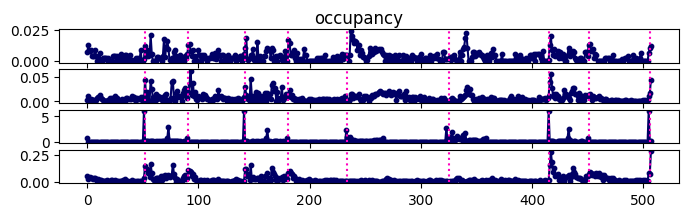

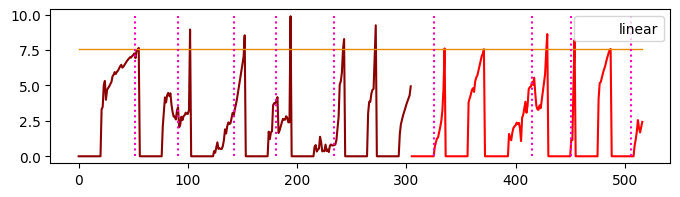

In [29]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp((df, title), changepoints=cps)
plt.show()

s_lin_train = np.concatenate([S_lin_train, np.array([0] * (data_val.shape[0] - S_lin_train.shape[0]))])
all_data = s_lin.shape[0]

plt.plot(s_lin_train,  color="darkred")#, label="train data")
plt.plot(range(s_lin_train.shape[0], s_lin_train.shape[0] + S_lin_test.shape[0]), S_lin_test, color="red")#, label="test data")
plt.plot([z] * all_data, color="#e68a00", lw=1)#, label="threshold")
plt.plot(1, lw=0, label="linear")
plt.vlines(x=cps,  ymin=s_lin.min(), ymax=s_lin.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper right')

#### With a class of neural networks

In [35]:
#TRAIN
z=5
verbose=True
min_diff=5

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print(change_points_val)


# Initialization of the test statistic
S_nn_train = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []

# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_val[st_nn + 1:], threshold=z, n_epochs=20, delta_max=50)

    S_nn_train = np.append(S_nn_train, new_S_nn)

    st_nn += new_st_nn
    change_points_nn += [int(st_nn)]

    if(new_st_nn > 0):
        if verbose:  
            print('Detected change point:', st_nn)
            
        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_nn > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_nn += 1
        else:
            skipped_cp = 0
            
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_nn:
                
                #skipped change points delays
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_nn <= min_diff):
                delays_nn = np.append(delays_nn, np.array([0.0]), axis=0)


                #skipped change points delays
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_nn = np.append(delays_nn,\
                                np.array([st_nn - change_points_val[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_nn = np.append(delays_nn, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print(f'Neural networks. z:{z}, Number of false alarms:', false_alarms_nn,\
    '; average delay:', np.mean(delays_nn), '±', np.std(delays_nn))

[ 52  91 142 181 234]
Detected change point: 57
Detected change point: 101
Detected change point: 149
Detected change point: 192
Detected change point: 239
Detected change point: 276
False Alarm
Neural networks. z:5, Number of false alarms: 1 ; average delay: 7.6 ± 2.4979991993593593


In [31]:
#TRAIN
z=5
verbose=True
min_diff=5

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print(change_points_val)


# Initialization of the test statistic
S_nn_train = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []

# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_val[st_nn + 1:], threshold=z, n_epochs=20, delta_max=50)

    S_nn_train = np.append(S_nn_train, new_S_nn)

    st_nn += new_st_nn
    change_points_nn += [int(st_nn)]

    if(new_st_nn > 0):
        if verbose:  
            print('Detected change point:', st_nn)
            
        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_nn > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_nn += 1
        else:
            skipped_cp = 0
            
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_nn:
                
                #skipped change points delays
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_nn <= min_diff):
                delays_nn = np.append(delays_nn, np.array([0.0]), axis=0)


                #skipped change points delays
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_nn = np.append(delays_nn,\
                                np.array([st_nn - change_points_val[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_nn = np.append(delays_nn, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print(f'Neural networks. z:{z}, Number of false alarms:', false_alarms_nn,\
    '; average delay:', np.mean(delays_nn), '±', np.std(delays_nn))

[ 52  91 142 181 234]
Detected change point: 58
Detected change point: 102
Detected change point: 150
Detected change point: 191
Detected change point: 239
Detected change point: 275
False Alarm
Neural networks. z:5, Number of false alarms: 1 ; average delay: 8.0 ± 2.280350850198276


In [32]:
# TEST
verbose=True
min_diff = 5
z = 5
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_nn_test = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []

# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_test[st_nn + 1:], threshold=z, n_epochs=20, delta_max=50)

    S_nn_test = np.append(S_nn_test, new_S_nn)

    st_nn += new_st_nn
    change_points_nn += [int(st_nn)]

    if(new_st_nn > 0):
        if verbose:  
            print('Detected change point:', st_nn)
            
        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_nn > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_nn += 1
        else:
            skipped_cp = 0
            
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_nn:
                
                #skipped change points delays TODO:
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_nn <= min_diff):
                delays_nn = np.append(delays_nn, np.array([0.0]), axis=0)


                #skipped change points delays TODO:
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_nn = np.append(delays_nn,\
                                  np.array([st_nn - change_points_test[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_nn = np.append(delays_nn, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_nn = np.append(delays_nn, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('Neural networks. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.mean(delays_nn), '±', np.std(delays_nn))

Test change points: [ 25 115 151 206]
Detected change point: 30
Detected change point: 68
False Alarm
Detected change point: 121
Detected change point: 161
Neural networks. Number of false alarms: 1 ; average delay: 5.75 ± 2.8613807855648994


In [41]:
# joblib.dump(S_nn_test, "stats/S_nn_test_occup.joblib")

['stats/S_nn_test_occup.joblib']

##### Final plot

In [33]:
s_nn = np.concatenate([S_nn_train, np.array([0] * (data_val.shape[0] - S_nn_train.shape[0])), S_nn_test])
s_nn.shape

(516,)

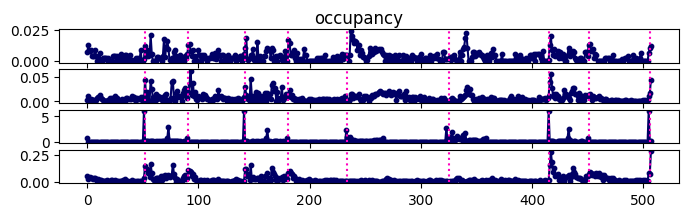

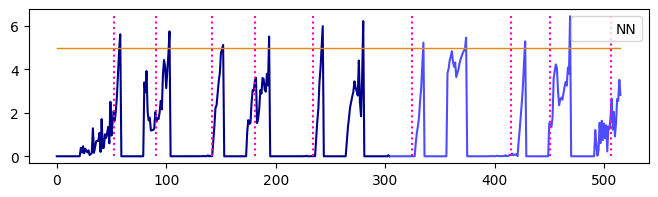

In [35]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp((df, title), changepoints=cps)
plt.show()

s_nn_train = np.concatenate([S_nn_train, np.array([0] * (data_val.shape[0] - S_nn_train.shape[0]))])
all_data = s_nn.shape[0]

plt.plot(s_nn_train,  color="darkblue")#, label="train data")
plt.plot(range(s_nn_train.shape[0], s_nn_train.shape[0] + S_nn_test.shape[0]), S_nn_test, color="#4d4dff")#, label="test data")
plt.plot([z] * all_data, color="#e68a00", lw=1)#, label="threshold")
plt.plot(1, lw=0, label="NN")
plt.vlines(x=cps,  ymin=s_nn.min(), ymax=s_nn.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper right')

### KLIEP

In [94]:
verbose = False
min_diff = 5

# The list of hyperparameters
sigma_list = [0.05, 0.2, 0.5, 1]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=20, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z-6.1, z, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        S_kliep = np.empty(0)

        # Initialization of the list of detected change points
        change_points_kliep = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_kliep = np.empty(0)
        current_change_point_ind = 0
        false_alarms_kliep = 0

        # Initialization
        st_kliep = 0
        new_st_kliep = 0
        
        while new_st_kliep >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                                window_size=20, sigma=sigma, threshold=z)

            S_kliep = np.append(S_kliep, new_S_kliep)

            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]

            if(new_st_kliep > 0):
                if verbose:  
                    print('Detected change point:', st_kliep)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_kliep > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_kliep += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_kliep:
                        
                        #skipped change points delays TODO:
                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_kliep <= min_diff):
                        delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_kliep = np.append(delays_kliep,\
                                        np.array([st_kliep - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_kliep = np.append(delays_kliep, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1


        print(f'KLIEP, threshold: {z}, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
            '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Validation change points: [ 52  91 142 181 234]
[30.86386328 31.54164106 32.21941884 32.89719661 33.57497439 34.25275217
 34.93052995 35.60830773 36.2860855  36.96386328]
KLIEP, threshold: 30.863863280969603, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.0 ± 18.76166303929372
KLIEP, threshold: 31.54164105874738, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.0 ± 18.76166303929372
KLIEP, threshold: 32.21941883652516, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.0 ± 18.76166303929372
KLIEP, threshold: 32.897196614302935, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.0 ± 18.76166303929372
KLIEP, threshold: 33.57497439208071, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.0 ± 18.76166303929372
KLIEP, threshold: 34.252752169858496, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.4 ± 18.2931681236466
KLIEP, threshold: 34.93052994763627, sigma = 0.05 . Number of false alarms: 0 ; average delay: 33.6 ± 18.10

In [36]:
# TRAIN

min_diff = 5
verbose=True
sigma = 0.5
z = 1.6645172634576033

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)


S_kliep_train = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0

while new_st_kliep >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                        window_size=20, sigma=sigma, threshold=z)

    S_kliep_train = np.append(S_kliep_train, new_S_kliep)

    st_kliep += new_st_kliep
    change_points_kliep += [int(st_kliep)]

    if(new_st_kliep > 0):
        if verbose:  
            print('Detected change point:', st_kliep)

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_kliep > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_kliep += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_kliep:
                
                #skipped change points delays TODO:
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_kliep <= min_diff):
                delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_kliep = np.append(delays_kliep,\
                                np.array([st_kliep - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_kliep = np.append(delays_kliep, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1


print(f'KLIEP, threshold: {z}, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
    '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Validation change points: [ 52  91 142 181 234]
Detected change point: 51
Detected change point: 92
Detected change point: 141
Detected change point: 200
Detected change point: 241
Detected change point: 286
False Alarm
KLIEP, threshold: 1.6645172634576033, sigma = 0.5 . Number of false alarms: 1 ; average delay: 5.4 ± 7.28285658241325


In [37]:
#TEST

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

min_diff = 5
verbose=True
sigma = 0.5
z = 1.6645172634576033
    
# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_kliep_test = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=20, sigma=sigma, threshold=z)

    S_kliep_test = np.append(S_kliep_test, new_S_kliep)

    st_kliep += new_st_kliep
    change_points_kliep += [int(st_kliep)]

    if(new_st_kliep > 0):
        if verbose:  
            print('Detected change point:', st_kliep)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_kliep > min_diff)):
            print("False Alarm")
            false_alarms_kliep += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_kliep:
                #skipped change points delays TODO:
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_kliep <= min_diff):
                delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)
                
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_kliep = np.append(delays_kliep,\
                                   np.array([st_kliep - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_kliep = np.append(delays_kliep, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
    
print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Test change points: [ 25 115 151 206]
Detected change point: 41
Detected change point: 82
False Alarm
Detected change point: 123
Detected change point: 170
KLIEP, sigma = 0.5 . Number of false alarms: 1 ; average delay: 11.25 ± 6.684870978560469


#### Final plot

In [38]:
S_kliep_test = np.minimum(S_kliep_test, [10] * S_kliep_test.shape[0])

In [39]:
s_k = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0])), S_kliep_test])
s_k.shape

(516,)

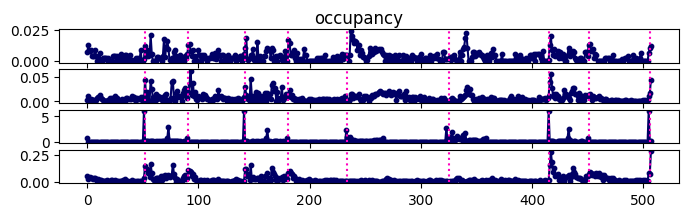

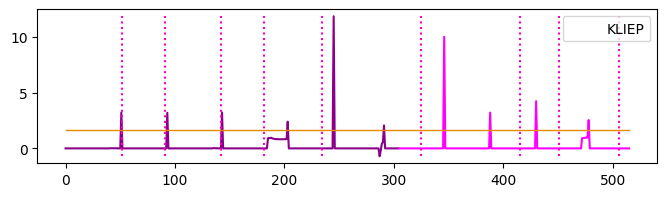

In [40]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp((df, title), changepoints=cps)
plt.show()

s_k_train = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0]))])
all_data = s_k.shape[0]

plt.plot(s_k_train, color="darkmagenta")#, label="train data")
plt.plot(range(s_k_train.shape[0], s_k_train.shape[0] + S_kliep_test.shape[0]), S_kliep_test, color="magenta")#, label="test data")
plt.plot([z] * all_data, color="#e68a00", lw=1)#, label="threshold")
plt.plot(1, lw=0, label="KLIEP")
plt.vlines(x=cps,  ymin=s_k.min(), ymax=s_k.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper right')

### M-statistic

In [58]:
verbose = False
min_diff = 5

# The list of hyperparameters
sigma_list = [0.05, 0.2, 0.5, 1]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=20, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    
    zs = np.linspace(4, 10, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        S_mmd = np.empty(0)

        # Initialization of the list of detected change points
        change_points_mmd = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_mmd = np.empty(0)
        current_change_point_ind = 0
        false_alarms_mmd = 0

        # Initialization
        st_mmd = 0
        new_st_mmd = 0
        
        while new_st_mmd >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                                window_size=20, sigma=sigma, threshold=z)

            S_mmd = np.append(S_mmd, new_S_mmd)

            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]

            if(new_st_mmd  > 0):
                if verbose:  
                    print('Detected change point:', st_mmd )

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_mmd  > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_mmd  += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_mmd :
                        if skipped_cp > 0:
                            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1

                        current_change_point_ind += 1
                    
                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_mmd  <= min_diff):
                        delays_mmd  = np.append(delays_mmd , np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_mmd  = np.append(delays_mmd ,\
                                        np.array([st_mmd - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0) 
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_mmd = np.append(delays_mmd, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1
        print(f'M-statistic, threshold: {z} sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
            '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Validation change points: [ 52  91 142 181 234]
[ 4.          4.66666667  5.33333333  6.          6.66666667  7.33333333
  8.          8.66666667  9.33333333 10.        ]
M-statistic, threshold: 4.0 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663604
M-statistic, threshold: 4.666666666666667 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663604
M-statistic, threshold: 5.333333333333333 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663604
M-statistic, threshold: 6.0 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663604
M-statistic, threshold: 6.666666666666666 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663604
M-statistic, threshold: 7.333333333333333 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663604
M-statistic, threshold: 8.0 sigma = 0.05 . Number of false alarms: 2 ; average delay: 24.0 ± 7.042726744663

In [41]:
# TRAIN

min_diff = 5
sigma = 0.2
verbose = True
z = 4

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)


# Initialization of the test statistic
S_mmd_train = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0

while new_st_mmd >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                        window_size=20, sigma=sigma, threshold=z)
    S_mmd_train = np.append(S_mmd_train, new_S_mmd)

    st_mmd += new_st_mmd
    change_points_mmd += [int(st_mmd)]

    if(new_st_mmd  > 0):
        if verbose:  
            print('Detected change point:', st_mmd )

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_mmd  > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_mmd  += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_mmd :
                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1
            
            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_mmd  <= min_diff):
                delays_mmd  = np.append(delays_mmd , np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_mmd  = np.append(delays_mmd ,\
                                np.array([st_mmd - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0) 
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_mmd = np.append(delays_mmd, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
print(f'M-statistic, threshold: {z} sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
    '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Validation change points: [ 52  91 142 181 234]
Detected change point: 54
Detected change point: 98
Detected change point: 145
Detected change point: 187
Detected change point: 234
Detected change point: 275
False Alarm
M-statistic, threshold: 4 sigma = 0.2 . Number of false alarms: 1 ; average delay: 3.6 ± 2.5768197453450252


In [42]:
#TEST

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 4
sigma = 0.2
verbose=True
    
# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_mmd_test = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                        window_size=20, sigma=sigma, threshold=z)

    S_mmd_test = np.append(S_mmd_test, new_S_mmd)

    st_mmd += new_st_mmd
    change_points_mmd += [int(st_mmd)]

    if(new_st_mmd > 0):
        if verbose:  
            print('Detected change point:', st_mmd)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_mmd > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_mmd += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_mmd :
                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_mmd <= min_diff):
                delays_mmd = np.append(delays_mmd, np.array([0.0]), axis=0)


                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_mmd = np.append(delays_mmd,\
                                   np.array([st_mmd - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_mmd = np.append(delays_mmd, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Test change points: [ 25 115 151 206]
Detected change point: 41
Detected change point: 82
False Alarm
Detected change point: 123
Detected change point: 166
M-statistic, sigma = 0.2 . Number of false alarms: 1 ; average delay: 10.25 ± 5.673402858955108


#### Final plot

In [43]:
S_mmd_test = np.minimum(S_mmd_test, [10] * S_mmd_test.shape[0])

In [44]:
s_m = np.concatenate([S_mmd_train, np.array([0] * (data_val.shape[0] - S_mmd_train.shape[0])), S_mmd_test])
s_m.shape

(516,)

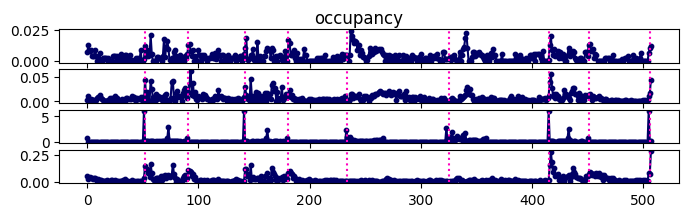

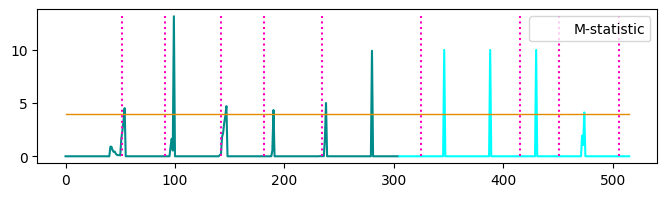

In [45]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp((df, title), changepoints=cps)
plt.show()

s_m_train = np.concatenate([S_mmd_train, np.array([0] * (data_val.shape[0] - S_mmd_train.shape[0]))])
all_data = s_m.shape[0]

plt.plot(s_m_train,  color="darkcyan")#, label="train data")
plt.plot(range(s_m_train.shape[0], s_m_train.shape[0] + S_mmd_test.shape[0]), S_mmd_test, color="cyan")#, label="test data")
plt.plot([z] * all_data, color="#e68a00", lw=1)#, label="threshold")
plt.plot(1, lw=0, label="M-statistic")
plt.vlines(x=cps,  ymin=s_m.min(), ymax=s_m.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper right')